# **NLP Language Model on QQD**

Dataset : https://www.kaggle.com/competitions/quora-question-pairs/data

*Key features* about the data :

1. Data is labelled - `Binary Classification ()` problem

2. Labels have been supplied by humans, so truth labels are inherently subjective. Therefore, the `labels` on this dataset should be taken as informed and `not 100% accurate`.

---

**Problem Statement** 

`Given two questions we have to classify whether they are duplicates or not`.

---

**Background**

Currently, Quora uses a `Random Forest model` to identify duplicate questions.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import OrderedDict
import operator
import nltk
from nltk import bigrams, trigrams, word_tokenize
from collections import Counter, defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("drive/MyDrive/Quora_Dataset/train.csv")

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df = df.drop(['id'], axis = 1)    # Dropped the id_column

In [ ]:
print("Number of Question pairs :", df.shape[0])
print(df.shape)

Number of Question pairs : 404290
(404290, 5)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404289 non-null  object
 3   question2     404288 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 15.4+ MB


In [ ]:
df.isnull().sum()

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

> There are few `missing values` in the *question1* and  *question2* columns.

- Can remove these few rows since the data is large enough or can think of other ways as well.

In [ ]:
# Dropping the Null values rows
df = df.dropna()
print(df.shape)

(404287, 5)


In [ ]:
df["question1"] = df["question1"].str.lower()
df["question2"] = df["question2"].str.lower()

##### **FEATURE ENGINEERING ON THE DATASET**

- Character length of a question
- Number of words in a question
- Number of common words in both questions
- Total unique words in both questions
- Word share ( Jaccard similarity )
- Unigram distance

In [ ]:
# Character length of a question

df["len1"] = df["question1"].str.len()
df["len2"] = df["question2"].str.len()

In [ ]:
# Number of words
df["word1"] = df["question1"].str.strip().str.split().str.len()
df["word2"] = df["question2"].str.strip().str.split().str.len()

In [ ]:
# Number of common words

def to_lower(d):
  a = [[x.lower() for x in s] for s in d]
  return a 

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1 |w2))

In [ ]:
df['common_words'] = df.apply(common_words, axis=1)
df['word_total'] = df.apply(total_words, axis=1)            # ? Should it be union or sum of unique words in both
df.head()

# In common words : Since we are using set to find intersection, if a word occurs twice in both questions it will be counted as 1 common

,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,common_words,word_total
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,10,13
1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,4,16
2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,73,59,14,10,4,20
3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19
4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,76,39,13,7,2,18


In [ ]:
df['word_share'] = round(df['common_words']/df['word_total'],2)
df.head()

,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,common_words,word_total,word_share
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,10,13,0.77
1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0,51,88,8,13,4,16,0.25
2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,73,59,14,10,4,20,0.20
3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0,19,0.00
4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0,76,39,13,7,2,18,0.11


In [ ]:
# Question lengths statistics
print('Minimum characters',df['len1'].min())
print('Maximum characters',df['len1'].max())
print('Average number of characters',int(df['len1'].mean()))

Minimum characters 1
Maximum characters 623
Average number of characters 59


In [ ]:
print('Minimum characters',df['len2'].min())
print('Maximum characters',df['len2'].max())
print('Average num of characters',int(df['len2'].mean()))

Minimum characters 1
Maximum characters 1169
Average num of characters 60


In [ ]:
# Removing rows where questions len <= 5 (open for suggestion)

df = df.drop(df.loc[df['len1'] <= 5].index)
df = df.drop(df.loc[df['len2'] <= 5].index)

In [ ]:
df = df.drop(df.loc[df['question1'] == 'deleted'].index)
df = df.drop(df.loc[df['question2'] == 'deleted'].index)
df = df.drop(df.loc[df['question1'] == 'deleted.'].index)
df = df.drop(df.loc[df['question2'] == 'deleted.'].index)
df = df.drop(df.loc[df['question1'] == 'delete'].index)
df = df.drop(df.loc[df['question2'] == 'delete'].index)
df = df.drop(df.loc[df['question1'] == '[removed]'].index)
df = df.drop(df.loc[df['question2'] == '[removed]'].index)

df.shape

(404199, 12)

Minimum words 1
Maximum words 125
Average num of words 10


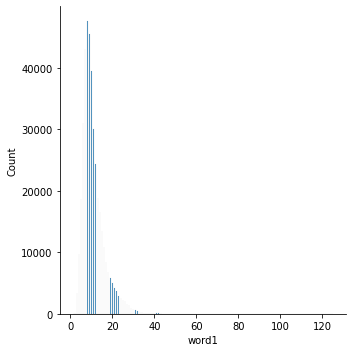

In [ ]:
sns.displot(df['word1'])
print('Minimum words',df['word1'].min())
print('Maximum words',df['word1'].max())
print('Average num of words',int(df['word1'].mean()))

Minimum words 1
Maximum words 237
Average num of words 11


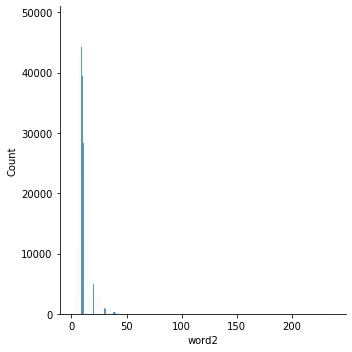

In [ ]:
sns.displot(df['word2'])

print('Minimum words',df['word2'].min())
print('Maximum words',df['word2'].max())
print('Average num of words',int(df['word2'].mean()))

In [ ]:
# Questions with words = 1 Are they of any use, seems useful ?

df.loc[df['word1'] == 2]

,qid1,qid2,question1,question2,is_duplicate,len1,len2,word1,word2,common_words,word_total,word_share
8361,16304,16305,cloud certification?,how do you show whether 2^n+5^n+2^(n+1) +5^(n+...,0,20,68,2,11,0,13,0.00
17465,33181,33182,female ejaculation?,what is female ejaculation exactly?,1,19,35,2,5,1,6,0.17
26370,49090,49091,reception definition?,why is everybody into engineering?,0,21,34,2,5,0,7,0.00
38449,69833,69834,clat 2017?,how do i prepare for clat 2017?,0,10,31,2,7,2,7,0.29
43906,78912,78913,phone numbe?,what are the fun things in your college sympos...,0,12,50,2,9,0,11,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
370050,500550,500551,offset wells?,"adult congenital heart disease, what is the be...",0,13,115,2,16,0,18,0.00
387603,118351,46690,what's linux?,what is the use of linux?,1,13,25,2,6,1,7,0.14
390644,523171,377857,what's english?,what is 睨んでるin english?,0,15,23,2,4,1,5,0.20
393619,166995,375724,call centre?,what is call centre?,1,12,20,2,4,2,4,0.50


### **Word share / Jaccard Similarity Plot**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


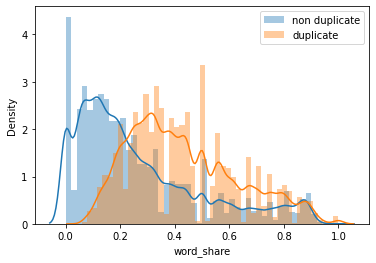

In [ ]:
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

In [ ]:
dup_word_share = (df.loc[df['is_duplicate']==1])['word_share']
non_dup_word_share = (df.loc[df['is_duplicate']==0])['word_share']

print("Mean word_share of non-duplicate pairs : " , non_dup_word_share.mean() )
print("Mean word_share of duplicate pairs : " , dup_word_share.mean() )

# box_data = [non_dup_word_share[0]] 

Mean word_share of non-duplicate pairs :  0.2645103515364699
Mean word_share of duplicate pairs :  0.43085139453708154


Text(0, 0.5, 'Word_Share')

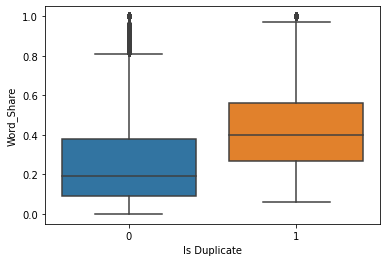

In [ ]:
ax = sns.boxplot( data=([non_dup_word_share,dup_word_share]))
# ax = sns.stripplot( data=([non_dup_word_share,dup_word_share]), color=".20")
plt.xlabel("Is Duplicate")
plt.ylabel("Word_Share")

##### **N-GRAM Distance** for duplicate and non-duplicate questions

In [ ]:
def diff_unigram(row):
    print(row['question1'])
    print(row['question2'])
    a = nltk.word_tokenize(row['question1'])
    b = nltk.word_tokenize(row['question2'])
    common = [] 
    cnt = 0 
    for i in a:
        for j in b:
            if i == j:
                cnt += 1
                common.append(i)
    return cnt/len(a), common

In [ ]:
df['uni_dist1'] = df.apply(diff_unigram(), axis=1)

### **PRE-PROCESSING FOR THE NLP MODEL**

In [ ]:
dups = df.loc[df['is_duplicate'] == 1][['question1','question2']]
duplicates1 = dups['question1'].tolist()
duplicates2 = dups['question2'].tolist()
dups_ques = duplicates1 + duplicates2
dups_ques[:10] 


['astrology: i am a capricorn sun cap moon and cap rising...what does that say about me?',
 'how can i be a good geologist?',
 'how do i read and find my youtube comments?',
 'what can make physics easy to learn?',
 'what was your first sexual experience like?',
 'what would a trump presidency mean for current international master’s students on an f1 visa?',
 'what does manipulation mean?',
 'why are so many quora users posting questions that are readily answered on google?',
 'why do rockets look white?',
 'how should i prepare for ca final law?']

In [ ]:
non_dups = df.loc[df['is_duplicate'] == 0][['question1','question2']]
non_duplicates1 = non_dups['question1'].tolist()
non_duplicates2 = non_dups['question2'].tolist()
non_dups_ques = non_duplicates1 + non_duplicates2
non_dups_ques[:10] 

['what is the step by step guide to invest in share market in india?',
 'what is the story of kohinoor (koh-i-noor) diamond?',
 'how can i increase the speed of my internet connection while using a vpn?',
 'why am i mentally very lonely? how can i solve it?',
 'which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'should i buy tiago?',
 'when do you use シ instead of し?',
 'motorola (company): can i hack my charter motorolla dcx3400?',
 'method to find separation of slits using fresnel biprism?',
 'what are the laws to change your status from a student visa to a green card in the us, how do they compare to the immigration laws in canada?']

In [ ]:
def Unigram_distr(dataset):

  model = defaultdict(lambda : 0)
  total_count = 0 
  for sentence in dataset:
    sentence = nltk.word_tokenize(sentence)
    for w1 in sentence:
      model[w1] += 1
      total_count += 1 ;

  for w1 in model:
      model[w1] /= total_count
  
  return model

In [ ]:
Unigram_model_dups = Unigram_distr(dups_ques)

In [ ]:
w1 = 'i' 
Unigram_model_dups[w1]  #Probabilty of w1 occuring 

0.022434145224556577

In [ ]:
def Bigram_distr(dataset):

  model = defaultdict(lambda: defaultdict(lambda: 0))

  for sentence in dataset:
    sentence = nltk.word_tokenize(sentence)
    for w1, w2 in bigrams(sentence):
      model[w1][w2] += 1

  for w1 in model:
    total_count = float(sum(model[w1].values()))
    for w2 in model[w1]:
      model[w1][w2] /= total_count
  
  return model

In [ ]:
Bigram_model_dups = Bigram_distr(dups_ques)

In [ ]:
# Bigram_model_dups[w1][w2] gives probabilty w2 next will occur given w1 is there

w1 = 'cricket'

cont = dict(Bigram_model_dups[w1])

sorted_tuples = sorted(cont.items(), key=operator.itemgetter(1), reverse = True)

sorted_choices = OrderedDict()
for k, v in sorted_tuples:
    sorted_choices[k] = v

# print('Given [' + w1 + '] what are possible next words and their probabilities :'  )
sorted_choices

In [ ]:
num = min(10,len(sorted_choices))   # Top `num` words with highest probabilty to be shown

top_choices = OrderedDict(list(sorted_choices.items())[0: num]) 

words = list(top_choices.keys())
probabs = list(top_choices.values())

fig, ax = plt.subplots()

bars = ax.bar( range(num), probabs , tick_label = words )

plt.xticks(rotation = 45)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Add text annotations to the top of the bars.
bar_color = bars[0].get_facecolor()
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 2),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

ax.set_xlabel('Top ' + str(num) + ' Words that most frequently follow : ' + w1, labelpad=15, color='#333333' , weight='bold')
ax.set_ylabel('Probability', labelpad=15, color='#333333', weight='bold')

# plt.bar(range(num), probabs)
plt.show()

In [ ]:
Bigram_model_non_dups = Bigram_distribution(non_dups_ques)

In [ ]:
# great , computer

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
drive.flush_and_unmount()